In [1]:
!pip install -Uqq fastai

In [2]:
from fastai.vision.all import *
import pandas as pd

matplotlib.rc('image', cmap='Greys')

# Sample of MNIST dataset - 3 and 7 only
Download dataset

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path

Show sample images

In [4]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

In [5]:
three_sample = Image.open(threes[1])
three_sample

In [6]:
seven_sample = Image.open(sevens[10])
seven_sample

In [7]:
three_tensor = tensor(three_sample)
df = pd.DataFrame(three_tensor[4:15, 4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


<Axes: >

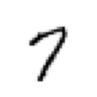

In [8]:
show_image(tensor(seven_sample))

## Classify 3's and 7's according to the average pixel value

Stack images into 3D tensors

In [9]:
threes_tensors = [tensor(Image.open(o)) for o in threes]
sevens_tensors = [tensor(Image.open(o)) for o in sevens]

stacked_threes = torch.stack(threes_tensors).float()/255
stacked_sevens = torch.stack(sevens_tensors).float()/255

Average every pixel

<Axes: >

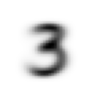

In [10]:
mean3 = stacked_threes.mean(0)
show_image(mean3)

<Axes: >

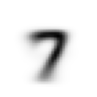

In [11]:
mean7 = stacked_sevens.mean(0)
show_image(mean7)

Compute distance of a sample 3 from the mean 3 and 7.
Distance from the mean 3 is lower than distance from the mean 7.

In [12]:
sample3 = stacked_threes[42]

dist_3_abs = (sample3 - mean3).abs().mean()
dist_3_sqr = ((sample3 - mean3)**2).mean().sqrt()

dist_7_abs = (sample3 - mean7).abs().mean()
dist_7_sqr = ((sample3 - mean7)**2).mean().sqrt()

print(f'3. L1 norm: {dist_3_abs:.5f}; L2 norm: {dist_3_sqr:.5f}')
print(f'7. L1 norm: {dist_7_abs:.5f}; L2 norm: {dist_7_sqr:.5f}')

3. L1 norm: 0.12104; L2 norm: 0.22165
7. L1 norm: 0.17686; L2 norm: 0.32937


Same thing using `torch.nn.functional` (imported as `F`)

In [13]:
F.l1_loss(sample3.float(), mean3), F.mse_loss(sample3, mean3).sqrt()

(tensor(0.1210), tensor(0.2216))

### Test the model against a validation set

In [14]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255

valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

In [15]:
def distance_from_mean(a, b):
    return (a - b).abs().mean((-1, -2)) # average along the last two axes

distance_from_mean(sample3, mean3), distance_from_mean(sample3, mean7)

(tensor(0.1210), tensor(0.1769))

Make use of PyTorch broadcasting to compute the distance between every tensor in the validation set and the average tensor (much faster than a loop)

In [16]:
valid_3_dist = distance_from_mean(valid_3_tens, mean3)
valid_3_dist.mean()

tensor(0.1296)

Define classification function

In [17]:
def is_3(x):
    return distance_from_mean(x, mean3) < distance_from_mean(x, mean7)

is_3(sample3)

tensor(True)

Compute accuracy

In [18]:
accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()
accuracy = (accuracy_3s + accuracy_7s) / 2

accuracy

tensor(0.9511)

# Computing gradients with PyTorch

In [19]:
xt = tensor([7., 2., -1.]).requires_grad_()

def f(x):
    return (x**2 - 2*x + 1).sum()

yt = f(xt)

yt.backward() # backpropagate gradient

xt.grad # show gradient

tensor([12.,  2., -4.])

## Example with simple 1D model

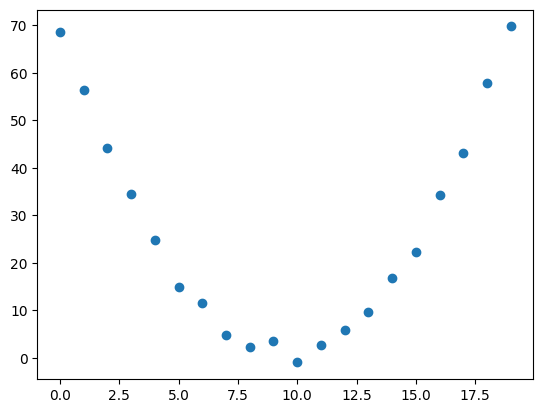

In [20]:
time = torch.arange(0, 20).float()
speed = torch.randn(20) + 0.75 * (time - 9.5)**2 + 1
plt.scatter(time, speed)

In [21]:
# speed function with adjustable parameters
def f(t, params):
    a, b, c = params
    return a * t**2 + b * t + c

# mean squared error function
def mse(preds, targets):
    return ((preds - targets)**2).mean()

# plot predictions
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300, 100)

In [22]:
# initialize parameters
params = torch.randn(3).requires_grad_()
orig_params = params.clone()

params

tensor([-0.6590, -0.6192,  0.4147], requires_grad=True)

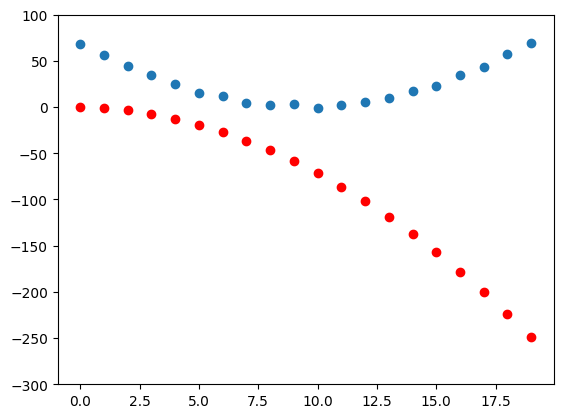

In [23]:
# make predictions
preds = f(time, params)
show_preds(preds)

In [24]:
# calculate loss
loss = mse(preds, speed)
loss

tensor(20348.5820, grad_fn=<MeanBackward0>)

In [25]:
# backpropagate gradients
loss.backward()
params.grad

tensor([-47077.7539,  -3025.4839,   -226.4417])

In [26]:
# update parameters
lr = 1e-5
params.data -= params.grad.data * lr
params.grad = None

params

tensor([-0.1882, -0.5889,  0.4170], requires_grad=True)

4380.40625
1358.7364501953125
786.9408569335938
678.736328125
658.2574462890625
654.37890625
653.6417846679688
653.4989624023438


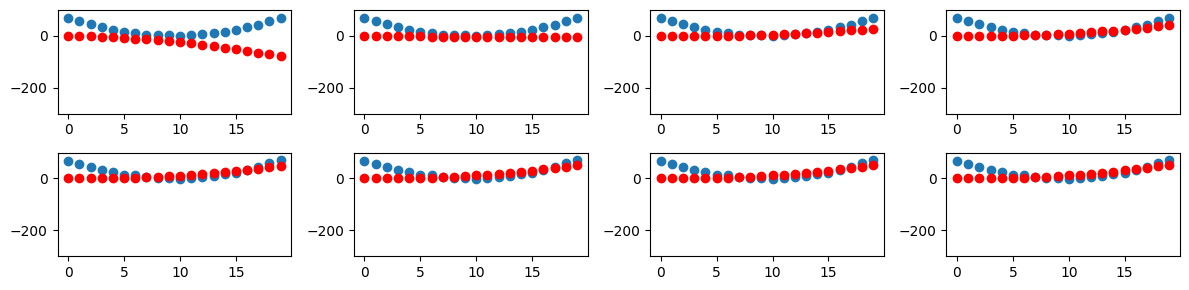

In [27]:
# repeat
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

_,axs = plt.subplots(2,4,figsize=(12,3))
for ax in axs.ravel(): show_preds(apply_step(params), ax)
plt.tight_layout()

# Gradient descent in MNIST

Create training and validation datasets:
* concatenate all training/validation data into one vector, and transform 2D pixel matrices into 1D vectors
* create labels as a sequence of 1's and 0's
* create dataset pairing each image with its label

In [28]:
x_train = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
y_train = tensor([1] * len(threes) + [0] * len(sevens)).unsqueeze(1)
dset_train = list(zip(x_train, y_train))

x_train.shape, y_train.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [29]:
x_valid = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
y_valid = tensor([1] * len(valid_3_tens) + [0] * len(valid_7_tens)).unsqueeze(1)
dset_valid = list(zip(x_valid, y_valid))

x_valid.shape, y_valid.shape

(torch.Size([2038, 784]), torch.Size([2038, 1]))

Initialize parameters

In [30]:
def init_params(size, std=1.):
    return (torch.randn(size) * std).requires_grad_()

weights = init_params((28*28, 1))
bias = init_params(1)

Make predictions on training dataset

In [31]:
def linear1(x):
    return x @ weights + bias

preds = linear1(x_train)
preds

tensor([[ 9.5542],
        [ 8.3013],
        [13.0523],
        ...,
        [-8.5849],
        [ 7.0387],
        [ 5.9690]], grad_fn=<AddBackward0>)

Check accuracy

In [32]:
corrects = (preds > 0.0).float() == y_train
corrects.float().mean().item()

0.5212165117263794

Define loss function

In [33]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid() # ensure predictions are between 0 and 1
    return torch.where(targets == 1, 1 - predictions, predictions).mean()

## Mini-batch SGD
Re-initialize parameters

In [34]:
weights = init_params((28*28, 1))
bias = init_params(1)

Create `DataLoader` to take mini-batches of the training set and shuffle them at each epoch

In [35]:
dl_train = DataLoader(dset_train, batch_size=256)
dl_valid = DataLoader(dset_valid, batch_size=256)

xd, yd = first(dl_train)
xd.shape, yd.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

For each epoch:
* compute predictions
* compute gradients
* update parameters
* reset gradients to zero (otherwise PyTorch would keep adding them up)
* compute accuracy to display

(note: PyTorch methods ending with an underscore modify objects in place)

In [36]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()
    
def train_epoch(model, lr, params):
    for xb, yb in dl_train:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad * lr
            p.grad.zero_()

In [37]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds > 0.5) == yb
    return correct.float().mean()


def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in dl_valid]
    return round(torch.stack(accs).mean().item(), 4)

In [38]:
lr = 1.
params = (weights, bias)

for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end='  ')

0.8218  0.9062  0.932  0.9418  0.9462  0.951  0.9545  0.9569  0.9584  0.9608  0.9603  0.9632  0.9652  0.9672  0.9681  0.9696  0.9696  0.9706  0.9716  0.9725  

## Creating an optimizer

Replace handmade linear model with PyTorch's `nn.Linear`. This includes parameter initialization and linear model creation. The parameters can be accessed through `nn.Linear.parameters()`.

In [39]:
linear_model = nn.Linear(28*28, 1)

w, b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

Create optimizer class, including method for updating parameters and method for resetting gradients

In [40]:
class BasicOptim:
    def __init__(self, params, lr): 
        self.params, self.lr = list(params), lr

    def step(self, *args, **kwargs):
        for p in self.params: 
            p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: 
            p.grad = None

Create optimizer and simplify epoch training function

In [41]:
opt = BasicOptim(linear_model.parameters(), lr)

def train_epoch(model):
    for xb, yb in dl_train:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

Train model

In [42]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end='  ')
        
train_model(linear_model, 20)

0.4932  0.8374  0.8364  0.9111  0.9326  0.9453  0.9545  0.9623  0.9658  0.9667  0.9682  0.9711  0.9726  0.975  0.976  0.9765  0.9775  0.9775  0.978  0.9785  

## Use FastAI library functions
Use FastAI's `SGD` class instead of `BasicOptimizer`

In [43]:
linear_model = nn.Linear(28*28, 1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932  0.8281  0.8476  0.9145  0.9331  0.9472  0.9565  0.9623  0.9653  0.9677  0.9702  0.9721  0.9741  0.975  0.976  0.977  0.9775  0.978  0.9785  0.9785  

Use FastAI's `Learner.fit()` instead of `train_model`. To do so, we need to load the data into a `DataLoaders`

In [44]:
dls = DataLoaders(dl_train, dl_valid)
learn = Learner(dls, nn.Linear(28*28, 1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

learn.fit(20, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637112,0.503690,0.495584,00:00
1,0.626645,0.115841,0.924926,00:00
2,0.226182,0.284064,0.721786,00:00
3,0.097728,0.134577,0.882237,00:00
4,0.049993,0.090614,0.919529,00:00
5,0.031399,0.069885,0.938665,00:00
6,0.023739,0.057643,0.951914,00:00
7,0.020370,0.049707,0.959764,00:00
8,0.018709,0.044270,0.964181,00:00
9,0.017749,0.040358,0.966143,00:00


## Adding a nonlinearity
Create a simple neural network containing a single hidden layer with 30 neurons. This is achieved with `nn.Sequential`, which is a model containing a sequence of models. 

In [45]:
simple_net = nn.Sequential(nn.Linear(28*28, 30),
                           nn.ReLU(),
                           nn.Linear(30, 1))

In [46]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.339217,0.406252,0.505888,00:00
1,0.155670,0.239525,0.790481,00:00
2,0.085086,0.118616,0.912169,00:00
3,0.055166,0.079462,0.942591,00:00
4,0.041383,0.061868,0.954858,00:00
5,0.034401,0.052027,0.963690,00:00
6,0.030424,0.045853,0.965653,00:00
7,0.027862,0.041636,0.966634,00:00
8,0.026028,0.038567,0.968597,00:00
9,0.024615,0.036217,0.970069,00:00


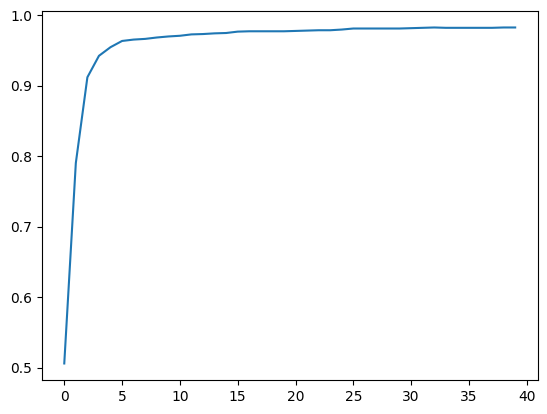

In [47]:
plt.plot(L(learn.recorder.values).itemgot(2))